In [18]:
import numpy as np
from centpy import *
# Setup up visualization
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.dpi']  = 60
import matplotlib.pyplot as plt
from matplotlib import animation

j0 = slice(2, -2)

We solve the equations of ideal magnetohydrodynamics in 1D 

\begin{equation} 
\partial_t 
\begin{bmatrix} 
\rho \\ \rho v_x \\ \rho v_y \\ \rho v_z \\ B_y \\ B_z \\ E 
\end{bmatrix} 
+ 
\partial_x 
\begin{bmatrix} 
\rho v_x \\ \rho v_x^2 + p^* - B_x^2 \\ \rho v_x v_y - B_x B_y \\
\rho v_x v_z - B_x B_z \\ B_y v_x - B_x v_y \\ B_z v_x - B_x v_z \\
(E+p^*) v_x - B_x (B_x v_x + B_y v_y + B_z v_Z) 
\end{bmatrix} 
= 0 
\end{equation}

where the total pressure is given by 

\begin{equation}
p^* = p + \frac{1}{2} (B_x^2 + B_y^2 + B_z^2)
\end{equation}

with the equation of state

\begin{equation}
p = (\gamma-1) \left(E-\frac{1}{2} \rho (v_x^2+v_y^2+v_z^2) - 
\frac{1}{2}(B_x^2 + B_y^2 + B_z^2)\right), \qquad \gamma=2.0
\end{equation}

The solution is computed on the domain $(x,t)\in([-1,1]\times[0,0.2])$ with initial data for a *Brio-Wu shock tube*:

\begin{equation}
(\rho, v_x, v_y, v_z, B_y, B_z, p)_{t=0} = 
\begin{cases}
(1,0,0,0,1,0,1) & \text{if} & -1<x\leq 0 \\
(0.125, 0, 0, 0, -1, 0, 0.1) & \text{if} & \ \ 0<x<1
\end{cases}
\end{equation}

and Dirichlet boundary data set by initial data on each boundary. The solution is computed using 400 cells and CFL number 0.475.

In [13]:
pars = centpy.Pars1d(
    x_init=-1.0, x_final=1.0, t_final=0.2, dt_out=0.002, J=400, cfl=0.475, scheme="fd2"
)
pars.B1 = 0.75

In [14]:
# MHD equation
class MHD1d(centpy.Equation1d):
    def pressure(self, u):
        return (
            u[:, 6]
            - 0.5 * ((u[:, 1] ** 2 + u[:, 2] ** 2 + u[:, 3] ** 2) / u[:, 0])
            - 0.5 * (self.B1 ** 2 + u[:, 4] ** 2 + u[:, 5] ** 2)
        )

    def initial_data(self):
        u = np.zeros((self.J + 4, 7))
        midpoint = int(self.J / 2) + 2

        # Left side
        u[:midpoint, 0] = 1.0
        u[:midpoint, 1] = 0.0
        u[:midpoint, 2] = 0.0
        u[:midpoint, 3] = 0.0
        u[:midpoint, 4] = 1.0
        u[:midpoint, 5] = 0.0
        u[:midpoint, 6] = 1.0 + 25.0 / 32.0

        # Right side
        u[midpoint:, 0] = 0.125
        u[midpoint:, 1] = 0.0
        u[midpoint:, 2] = 0.0
        u[midpoint:, 3] = 0.0
        u[midpoint:, 4] = -1.0
        u[midpoint:, 5] = 0.0
        u[midpoint:, 6] = 0.1 + 25.0 / 32.0

        return u

    def boundary_conditions(self, u):

        left_v = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0 + 25.0 / 32.0]
        right_v = [0.125, 0.0, 0.0, 0.0, -1.0, 0.0, 0.1 + 25.0 / 32]

        if self.odd:
            u[0] = left_v
            u[-1] = right_v
            u[-2] = right_v
        else:
            u[0] = left_v
            u[1] = left_v
            u[-1] = right_v

    def flux_x(self, u):
        f = np.zeros_like(u)

        B1 = self.B1

        p_star = self.pressure(u) + 0.5 * (B1 ** 2 + u[:, 4] ** 2 + u[:, 5] ** 2)

        f[:, 0] = u[:, 1]
        f[:, 1] = u[:, 1] ** 2 / u[:, 0] + p_star
        f[:, 2] = u[:, 1] * u[:, 2] / u[:, 0] - B1 * u[:, 4]
        f[:, 3] = u[:, 1] * u[:, 3] / u[:, 0] - B1 * u[:, 5]
        f[:, 4] = u[:, 1] * u[:, 4] / u[:, 0] - B1 * u[:, 2] / u[:, 0]
        f[:, 5] = u[:, 1] * u[:, 5] / u[:, 0] - B1 * u[:, 3] / u[:, 0]
        f[:, 6] = (u[:, 6] + p_star) * (u[:, 1] / u[:, 0]) - B1 * (
            B1 * u[:, 1] + u[:, 2] * u[:, 4] + u[:, 3] * u[:, 5]
        ) / u[:, 0]

        return f

    def spectral_radius_x(self, u):
        rho = u[:, 0]
        u_x = u[:, 1] / rho
        p = self.pressure(u)
        A = 2.0 * p / rho
        B = (self.B1 ** 2 + u[:, 4] ** 2 + u[:, 5] ** 2) / rho
        cf = np.sqrt(
            0.5 * (A + B + np.sqrt((A + B) ** 2 - 4.0 * A * self.B1 ** 2 / rho))
        )
        return np.abs(u_x) + cf

In [15]:
eqn = MHD1d(pars)
soln = centpy.Solver1d(eqn)
soln.solve()

<IPython.core.display.Javascript object>


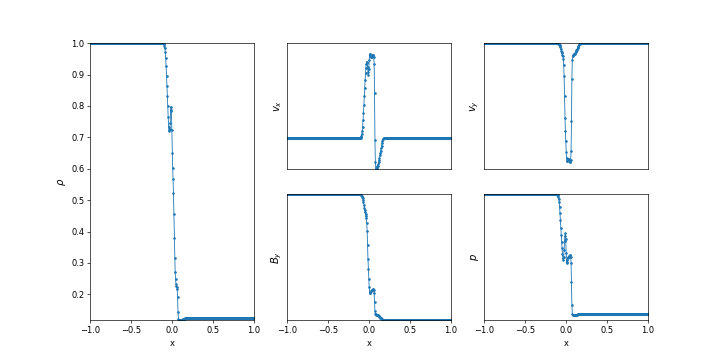

In [19]:
# Animation 
 
u_n = soln.u_n.copy()
x   = soln.x.copy()
Nt  = soln.Nt 
pressure = eqn.pressure
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(12,6))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(2,3,2)
ax3=fig.add_subplot(2,3,3)
ax4=fig.add_subplot(2,3,5)
ax5=fig.add_subplot(2,3,6)
#ax = plt.axes(xlim=(x_init,x_final), ylim=(np.min(u_n), np.max(u_n)*1.1))

line_u1, = ax1.plot([], [], linewidth=1, marker='o', markersize=2)
line_u2, = ax2.plot([], [], linewidth=1, marker='o', markersize=2)
line_u3, = ax3.plot([], [], linewidth=1, marker='o', markersize=2)
line_u4, = ax4.plot([], [], linewidth=1, marker='o', markersize=2)
line_u5, = ax5.plot([], [], linewidth=1, marker='o', markersize=2)

ax1.set_xlabel('x')
ax4.set_xlabel('x')
ax5.set_xlabel('x')

ax2.set_xticks([])
ax3.set_xticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax5.set_yticks([])

ax1.set_ylabel(r'$\rho$', fontsize=12)
ax2.set_ylabel(r'$v_x$', fontsize=12)
ax3.set_ylabel(r'$v_y$', fontsize=12)
ax4.set_ylabel(r'$B_y$', fontsize=12)
ax5.set_ylabel(r'$p$', fontsize=12)

# Primitive variables
rho=u_n[:,j0,0]
v_x = u_n[:,j0,1]/u_n[:,j0,0]
v_y = u_n[:,j0,2]/u_n[:,j0,0]
B_y = u_n[:,j0,4]

ax1.set_xlim(-1, 1)
ax2.set_xlim(-1, 1)
ax3.set_xlim(-1, 1)
ax4.set_xlim(-1, 1)
ax5.set_xlim(-1, 1)
ax1.set_ylim(np.min(rho), np.max(rho))
ax2.set_ylim(np.min(v_x), np.max(v_x))
ax3.set_ylim(np.min(v_y), np.max(v_y))
ax4.set_ylim(np.min(B_y), np.max(B_y))
ax5.set_ylim(0.05, 1.)

#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

# initialization function: plot the background of each frame
def init():
    line_u1.set_data([], [])
    line_u2.set_data([], [])
    line_u3.set_data([], [])
    line_u4.set_data([], [])
    line_u5.set_data([], [])

# animation function.  This is called sequentially
def animate(i):
    p = pressure(u_n[i,j0,:])
    line_u1.set_data(x[j0], rho[i])
    line_u2.set_data(x[j0], v_x[i])
    line_u3.set_data(x[j0], v_y[i])
    line_u4.set_data(x[j0], B_y[i])
    line_u5.set_data(x[j0], p)
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt, interval=100, blit=False)
 
plt.show()